In [1]:
import pickle
import numpy as np
import pandas as pd
import os
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import load_model
import util
import importlib
import time
from util import create_snapshot_features
import sys
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
importlib.reload(util)



<module 'util' from '/Users/kolten/optiver/util.py'>

# part1

In [2]:
start_time_4 = time.time()
start_time_1 = time.time()

# Step 1: Compute snapshot features resotring to snapshot_features_df and save rolling window to be stock_22753_df
snapshot_features_df_50200 = pd.read_csv("snapshot_features_df_50200.csv")

rolling_features_df_50200 = pd.read_csv("stock_50200.csv")

# Preview
print("Rolling features:", rolling_features_df_50200.shape)
display(rolling_features_df_50200.head())

print("Rolling features:", snapshot_features_df_50200.shape)
display(snapshot_features_df_50200.head())


MODEL_PATH = 'config_v256d03.h5'
SCALER_PATH = 'config_v256d03_scalers.pkl'

with open(SCALER_PATH, 'rb') as f:
    config = pickle.load(f)
model = load_model(MODEL_PATH, compile=False)

end_time_1 = time.time()


Rolling features: (833290, 25)


,stock_id,time_id,start_time,wap_mean,wap_std,wap_max,wap_min,spread_pct_mean,spread_pct_std,spread_pct_max,...,depth_ratio_mean,depth_ratio_std,depth_ratio_max,depth_ratio_min,log_return_mean,log_return_std,log_return_max,log_return_min,realized_volatility,datetime
0,50200.0,6.0,1800.0,372.347747,0.152688,372.598023,372.036666,0.000037,0.000013,0.000054,...,7.589939,44.479523,395.999604,0.033333,-0.000003,0.000046,0.000159,-0.000207,0.000235,NaN
1,50200.0,6.0,1802.0,372.340905,0.156816,372.598023,371.955111,0.000038,0.000013,0.000054,...,7.582752,44.480654,395.999604,0.033333,-0.000004,0.000048,0.000159,-0.000219,0.000356,NaN
2,50200.0,6.0,1805.0,372.332872,0.163290,372.598023,371.934998,0.000038,0.000013,0.000054,...,7.566621,44.482415,395.999604,0.033333,-0.000004,0.000048,0.000159,-0.000219,0.000357,NaN
3,50200.0,6.0,1807.0,372.326948,0.165921,372.598023,371.934998,0.000037,0.000013,0.000054,...,7.510483,44.485172,395.999604,0.033333,-0.000004,0.000051,0.000340,-0.000219,0.000162,NaN
4,50200.0,6.0,1810.0,372.319845,0.168082,372.598023,371.934998,0.000037,0.000013,0.000054,...,7.508179,44.485539,395.999604,0.033333,-0.000004,0.000050,0.000340,-0.000219,0.000179,NaN


Rolling features: (4166788, 22)


,stock_id,time_id,seconds_in_bucket,bid_price1,ask_price1,bid_price2,ask_price2,bid_size1,ask_size1,bid_size2,...,wap,bid_ask_spread,spread_pct,imbalance,depth_ratio,log_return,log_wap_change,rolling_std_logret,spread_zscore,volume_imbalance
0,50200,6,1800.0,372.48,372.50,372.47,372.51,200,200,1408,...,372.489999,0.02,0.000054,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0
1,50200,6,1800.0,372.48,372.50,372.47,372.51,200,200,1408,...,372.489999,0.02,0.000054,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0
2,50200,6,1801.0,372.47,372.48,372.46,372.49,435,830,608,...,372.473438,0.01,0.000027,-0.312253,0.524096,-0.000044,-0.000044,0.000026,-1.154701,10
3,50200,6,1801.0,372.47,372.48,372.46,372.49,435,830,608,...,372.473438,0.01,0.000027,-0.312253,0.524096,0.000000,0.000000,0.000022,-0.866025,10
4,50200,6,1802.0,372.46,372.47,372.45,372.48,100,100,508,...,372.464998,0.01,0.000027,0.000000,1.000000,-0.000023,-0.000023,0.000020,-0.730264,0


## Feature Engineering

In [3]:

start_time_2 = time.time()

seq_df = util.generate_tick_sequences(
    snapshot_features_df_50200,
    feature_cols=["wap","spread_pct","imbalance","depth_ratio","log_return"],
    window=config.get('window', util.WINDOW_SIZE),
    horizon=config.get('horizon', util.FORECAST_HORIZON),
    step=config.get('step', util.STEP)
)

subset = seq_df.iloc[-len(seq_df) // 5:]  # rencetly 20%
X = np.stack(subset['X'].values)         # shape: (n_samples, window, n_features)
y_true = subset['y'].values              # shape: (n_samples,)

n_samples, window, n_feats = X.shape
X_scaled = config['x_scaler'].transform(X.reshape(-1, n_feats)).reshape(n_samples, window, n_feats)
y_scaled = config['y_scaler'].transform(y_true.reshape(-1, 1)).flatten()

end_time_2 = time.time()

## model test

In [4]:
start_time_3 = time.time()
y_pred_scaled = model.predict(X_scaled)
y_pred_2 = config['y_scaler'].inverse_transform(y_pred_scaled).flatten()

#merge snapshot_features_df and get bas
snapshot_subset = pd.merge(
    subset[['time_id', 'start_time']],
    snapshot_features_df_50200[['time_id', 'seconds_in_bucket', 'bid_ask_spread']],
    left_on=['time_id', 'start_time'],
    right_on=['time_id', 'seconds_in_bucket'],
    how='left'
)

results_df = pd.DataFrame({
    'time_id': subset['time_id'].values,
    'start_time': subset['start_time'].values,
    'y_true_2': subset['y'].values,
    'y_pred_2': y_pred_2,
    'bid_ask_spread': snapshot_subset['bid_ask_spread'].values  # add bas
})


#from DataFrame
y_true_2 = results_df['y_true_2'].values

mse = mean_squared_error(y_true_2, y_pred_2)
qlike = np.mean((y_true_2 - y_pred_2) ** 2 / (y_true_2 ** 2))

print(f"Performance:")
print(f"  • MSE   = {mse:.6e}")
print(f"  • QLIKE = {qlike:.6e}")


end_time_3 = time.time()


4722/4722 ━━━━━━━━━━━━━━━━━━━━ 519s 110ms/step
Performance:
  • MSE   = 3.285963e-09
  • QLIKE = 4.324844e-01


## visualization

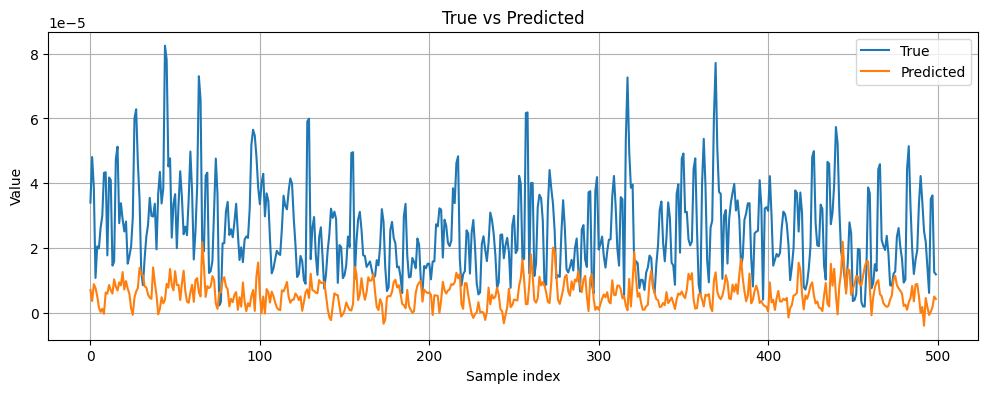

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.plot(y_true_2[:500], label="True")
plt.plot(y_pred_2[:500], label="Predicted")
plt.legend()
plt.title("True vs Predicted")
plt.xlabel("Sample index")
plt.ylabel("Value")
plt.grid(True)
plt.show()


Mean Residual: 0.000033
Std of Residual: 0.000047
Min Residual: -0.000151
Max Residual: 0.000952


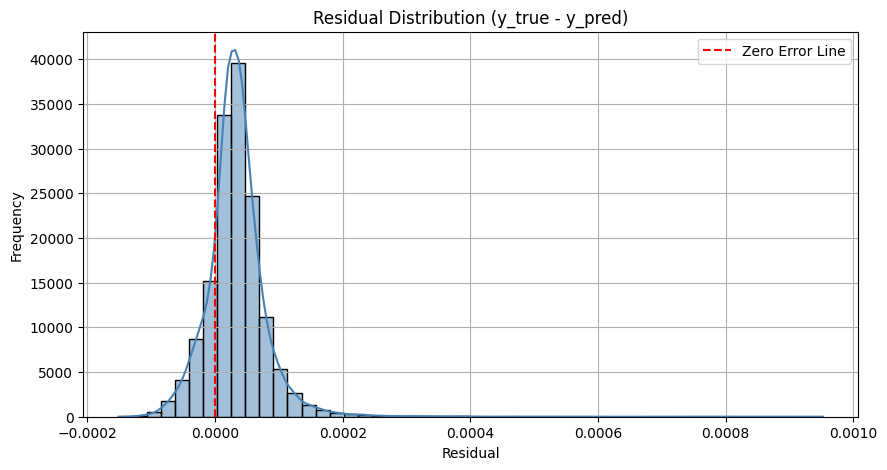

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


residuals = y_true_2 - y_pred_2

print(f"Mean Residual: {np.mean(residuals):.6f}")
print(f"Std of Residual: {np.std(residuals):.6f}")
print(f"Min Residual: {np.min(residuals):.6f}")
print(f"Max Residual: {np.max(residuals):.6f}")

plt.figure(figsize=(10, 5))
sns.histplot(residuals, kde=True, bins=50, color='steelblue')
plt.title("Residual Distribution (y_true - y_pred)")
plt.xlabel("Residual")
plt.ylabel("Frequency")
plt.axvline(0, color='red', linestyle='--', label='Zero Error Line')
plt.legend()
plt.grid(True)
plt.show()


## Time

In [8]:
end_time_4 = time.time()

print(f"Model and Feature Loading Phase time: {end_time_1 - start_time_1:.2f} seconds")
print(f"Feature Engineering: {end_time_2 - start_time_2:.2f} seconds")
print(f"model run time: {end_time_3 - start_time_3:.2f} seconds")
print(f"average of every sample run time: {(end_time_3 - start_time_3)/4176:.6f} seconds")
print(f"Total computation time: {end_time_4 - start_time_4:.2f} seconds")


Model and Feature Loading Phase time: 7.07 seconds
Feature Engineering: 126.81 seconds
model run time: 520.68 seconds
average of every sample run time: 0.124684 seconds
Total computation time: 655.42 seconds


# part2 - BAS

## XGboost model for 50200

define a function of build_spread_features(), perpare for the future work in different stock

In [9]:
start_time_a = time.time()
start_time_c = time.time()
def build_spread_features(results_df):

    # Step 1: lag features
    results_df = results_df.sort_values(by=['time_id', 'start_time'])

    results_df['spread_lag1'] = results_df['bid_ask_spread'].shift(1)
    results_df['spread_lag2'] = results_df['bid_ask_spread'].shift(2)
    results_df['vol_pred_lag1'] = results_df['y_pred_2'].shift(1)

    results_df['spread_roll_mean_5'] = results_df.groupby('time_id')['bid_ask_spread'].transform(lambda x: x.rolling(5).mean())
    results_df['spread_roll_std_5'] = results_df.groupby('time_id')['bid_ask_spread'].transform(lambda x: x.rolling(5).std())

    # Step 2:  future +1 spread
    results_df['spread_t_plus_1'] = results_df['bid_ask_spread'].shift(-1)

    # delete NA
    results_df = results_df.dropna(subset=[
        'spread_lag1', 'spread_lag2', 'vol_pred_lag1',
        'spread_roll_mean_5', 'spread_roll_std_5', 'spread_t_plus_1'
    ])

    # create X and y
    X_bas = results_df[[
        'y_pred_2',
        'vol_pred_lag1',
        'spread_lag1',
        'spread_lag2',
        'spread_roll_mean_5',
        'spread_roll_std_5'
    ]].values

    y_bas = results_df['spread_t_plus_1'].values
    
    return X_bas, y_bas

In [10]:

X_bas, y_bas = build_spread_features(results_df)

X_train, X_test, y_train, y_test = train_test_split(X_bas, y_bas, test_size=0.2, random_state=42)

model_bas = XGBRegressor()
model_bas.fit(X_train, y_train)

y_pred_bas = model_bas.predict(X_test)
mse_bas = mean_squared_error(y_test, y_pred_bas)

qlike= np.mean((y_test - y_pred_bas) ** 2 / (y_test ** 2))

print(f"MSE:{mse_bas:.6e}")

print(f"qlike:{qlike:.6e}")


MSE:1.561770e-05
qlike:6.655904e-02


In [24]:

param_grid = {
    'max_depth': [4, 6, 8],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 200, 300],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

grid_search = GridSearchCV(
    estimator=XGBRegressor(random_state=42, n_jobs=-1),
    param_grid=param_grid,
    scoring='neg_mean_squared_error',
    cv=3,
    verbose=1
)

grid_search.fit(X_train, y_train)

print(f" best turn: {grid_search.best_params_}")
print(f" minimum MSE: {-grid_search.best_score_:.6e}")


Fitting 3 folds for each of 243 candidates, totalling 729 fits
 best turn: {'colsample_bytree': 1.0, 'learning_rate': 0.05, 'max_depth': 4, 'n_estimators': 100, 'subsample': 0.8}
 minimum MSE: 2.029055e-05


In [12]:
model_bas = XGBRegressor(
    n_estimators=300,       
    max_depth=4,            
    learning_rate=0.01,     
    subsample=0.8,          
    colsample_bytree=1.0,   
    random_state=3888,        

)
model_bas.fit(X_train, y_train)

y_pred_bas = model_bas.predict(X_test)
mse_bas = mean_squared_error(y_test, y_pred_bas)

qlike= np.mean((y_test - y_pred_bas) ** 2 / (y_test ** 2))

print(f"MSE:{mse_bas:.6e}")

print(f"qlike:{qlike:.6e}")

end_time_a =time.time()

MSE:1.540607e-05
qlike:6.448773e-02


## XGboost model for 104919

In [13]:
start_time_b =  time.time()
snapshot_features_df_104919 = pd.read_csv("snapshot_features_df_104919.csv")


Use the y output from part 1 to predict bas, aligning the time first.

In [14]:

df_pred_50200 = pd.DataFrame({
    'time_id': subset['time_id'].values,
    'start_time': subset['start_time'].values,
    'y_pred_2': y_pred_2
})

merged_df = pd.merge(
    snapshot_features_df_104919,
    df_pred_50200,
    left_on=['time_id', 'seconds_in_bucket'],
    right_on=['time_id', 'start_time'],
    how='inner'
)

snapshot_subset = snapshot_features_df_104919[[
    'time_id', 'seconds_in_bucket', 'bid_ask_spread'
]]

results_df_2 = pd.merge(
    snapshot_subset,
    df_pred_50200,
    left_on=['time_id', 'seconds_in_bucket'],
    right_on=['time_id', 'start_time'],
    how='inner'
)



In [19]:

X_bas, y_bas = build_spread_features(results_df_2)

X_train, X_test, y_train, y_test = train_test_split(X_bas, y_bas, test_size=0.2, random_state=42)

model_bas = XGBRegressor(
    n_estimators=100,       
    max_depth=4,            
    learning_rate=0.05,     
    subsample=0.8,          
    colsample_bytree=1.0,   
    random_state=3888,        

)
model_bas.fit(X_train, y_train)

y_pred_bas = model_bas.predict(X_test)
mse_bas = mean_squared_error(y_test, y_pred_bas)

qlike= np.mean((y_test - y_pred_bas) ** 2 / (y_test ** 2))

print(f"MSE:{mse_bas:.6e}")

print(f"qlike:{qlike:.6e}")
end_time_b =  time.time()

MSE:2.017704e-05
qlike:9.667830e-02


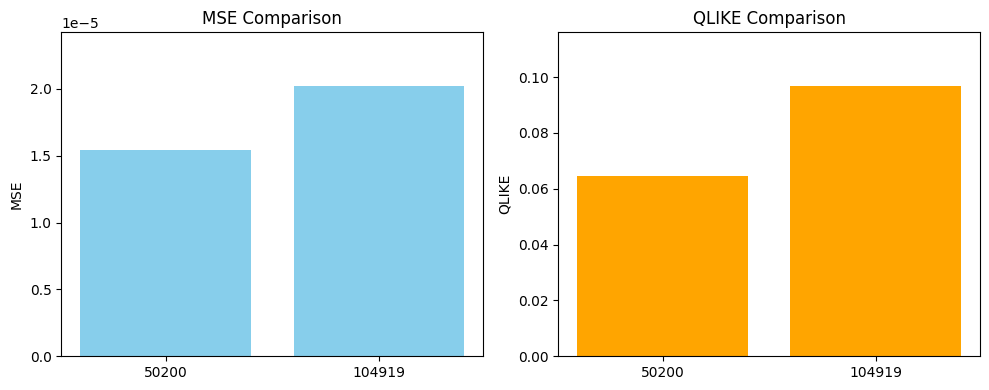

In [20]:
import matplotlib.pyplot as plt

labels = ['50200', '104919']

mse_values = [1.54e-05, 2.02e-05]
qlike_values = [6.45e-02, 9.67e-02]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

ax1.bar(labels, mse_values, color='skyblue')
ax1.set_title('MSE Comparison')
ax1.set_ylabel('MSE')
ax1.set_ylim(0, max(mse_values) * 1.2) 

ax2.bar(labels, qlike_values, color='orange')
ax2.set_title('QLIKE Comparison')
ax2.set_ylabel('QLIKE')
ax2.set_ylim(0, max(qlike_values) * 1.2)

plt.tight_layout()
plt.show()

end_time_c = time.time()


## Time

In [21]:

print(f"XGboost model for 50200: {end_time_a - start_time_a:.2f} seconds")
print(f"XGboost model for 104919: {(end_time_b - start_time_b)/4176:.6f} seconds")
print(f"Total computation time: {end_time_c - start_time_c:.2f} seconds")

XGboost model for 50200: 248.55 seconds
XGboost model for 104919: 0.069359 seconds
Total computation time: 540.29 seconds


# Quoting Price

In [22]:
results_df['mid_price'] = 100 + np.random.normal(0, 0.02, len(results_df))

y_scaled = (results_df['y_pred_2'] - results_df['y_pred_2'].mean()) / results_df['y_pred_2'].std()
results_df['alpha'] =  1.0 + 0.3 * y_scaled.clip(-1, 1)

results_df['quoted_bid'] = results_df['mid_price'] - results_df['alpha'] * results_df['y_pred_2'] / 2
results_df['quoted_ask'] = results_df['mid_price'] + results_df['alpha'] * results_df['y_pred_2'] / 2
results_df['real_bid'] = results_df['mid_price'] - results_df['bid_ask_spread'] / 2
results_df['real_ask'] = results_df['mid_price'] + results_df['bid_ask_spread'] / 2



By standardizing the predicted values, we convert them into a measure of volatility intensity relative to the average level (y_scaled). This volatility signal is then used to construct an adjustment factor alpha, which is clipped within a reasonable range (from -1 to 1). The alpha is ultimately applied to the quoting calculation, allowing the strategy to widen the quote range during periods of high market volatility and narrow it during calmer periods—enabling a more adaptive and risk-aware quoting approach.

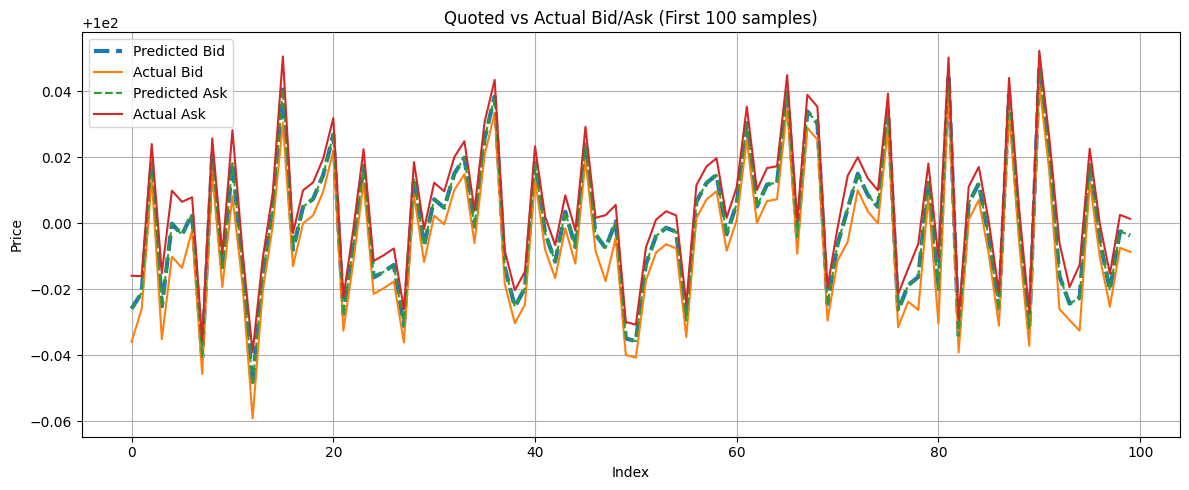

In [23]:

plt.figure(figsize=(12, 5))
plt.plot(results_df['quoted_bid'][:100], label='Predicted Bid', linestyle='--',linewidth=3,)
plt.plot(results_df['real_bid'][:100], label='Actual Bid', linestyle='-')
plt.plot(results_df['quoted_ask'][:100], label='Predicted Ask', linestyle='--')
plt.plot(results_df['real_ask'][:100], label='Actual Ask', linestyle='-')
plt.title("Quoted vs Actual Bid/Ask (First 100 samples)")
plt.xlabel("Index")
plt.ylabel("Price")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
